In [1]:
stock = str(2408)

In [4]:
import yaml
credentials = yaml.load(open('./credentials.yaml'), Loader=yaml.FullLoader)
import shioaji as sj
api = sj.Shioaji()
accounts = api.login(credentials['API']['YOUR_PERSON_ID'], credentials['API']['YOUR_PASSWORD'])
api.activate_ca(
    ca_path=credentials['activate_ca']['ca_path'],
    ca_passwd=credentials['activate_ca']['ca_passwd'],
    person_id=credentials['activate_ca']['person_id']
)

In [7]:
import pandas as pd
from statistics import stdev, mean
import datetime
import easygui
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from IPython.display import clear_output
class Quantitative:
    def __init__(self, stock):
        self.stock = stock
        datetime_dt = datetime.datetime.today()# 獲得當地時間
        self.today = datetime_dt.strftime("%Y-%m-%d") 
        self.state = 0 # 1:finding low point, 2: finding high point
    def std(self, date="2021-06-16"):
        """"計算前一天標準差"""
        ticks = api.ticks(
            contract=api.Contracts.Stocks[self.stock], 
            date=date
        )
        df = pd.DataFrame({**ticks})
        prices = df['close'].values[:]
        prices = prices[prices != 0.0]
        return stdev(prices)
    def num_to_buy(self, money=3000):
        """"欲購買金額的股數"""
        ticks = api.ticks(
            contract=api.Contracts.Stocks[self.stock], 
            date=self.today
        )
        df = pd.DataFrame({**ticks})
        price = df['close'].values[-1]
        return int(money/price)
    def announce(self, std_date="2021-06-16"):
        """"抄底、賣點通知"""
        std = self.std(std_date)
        ticks = api.ticks(
            contract=api.Contracts.Stocks[self.stock], 
            date=self.today
        )
        self.df = pd.DataFrame({**ticks})
        prices = self.df['close'].values[:]; prices = prices[prices != 0.0]
        if self.state == 0:
            if prices[-1] > mean(prices) + std:   
                self.state = 2
                easygui.msgbox(msg=f"相對高點：股價　{prices[-1]}", title="high")
            elif prices[-1] < mean(prices) - std: 
                self.state = 1
                easygui.msgbox(msg=f"相對低點：股價　{prices[-1]}", title="low")    
        elif self.state == 1: #抄底
            if prices[-1] > mean(prices[-200: -1]) and min(prices[-200: -1]) < min(prices[:-200]):
                n_stock = self.num_to_buy()
                easygui.msgbox(msg=f"抄底{n_stock}股", title="low")
                self.state = 0
        else:
            if prices[-1] < mean(prices[-200: -1]) and max(prices[-200: -1]) > max(prices[:-200]): # 賣
                easygui.msgbox(msg="賣", title="high")
                self.state = 0
    def plot(self):
        """"股票走勢圖"""
        clear_output(wait=True)
        x = np.array(range(len(self.df.index)))
        y = self.df['close'].values[:]
        price = self.df['close'].values[-1]
        X_Y_Spline = make_interp_spline(x, y)
        X_ = np.linspace(x.min(), x.max(), 500)
        Y_ = X_Y_Spline(X_)
        plt.plot(X_, Y_)
        plt.title(f"now price: {price}")
        plt.show()

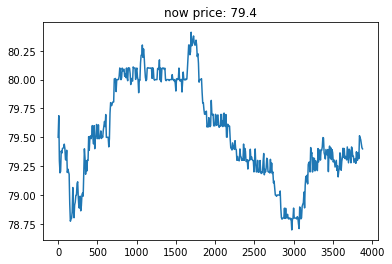

In [ ]:
import time
def get_time():
    datetime_dt = datetime.datetime.today()# 獲得當地時間
    return datetime_dt.strftime("%H:%M") 

qt = Quantitative(stock)

while get_time() != "13:30":
    qt.announce(std_date="2021-06-16")
    qt.plot()
    time.sleep(4)